In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.19.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import multiprocessing
import gc
from scipy.stats import kurtosis, skew # Import kurtosis

data_cfg = {
    'Input_param_names': ['ambient',
                          'coolant',
                          'u_d',
                          'u_q',
                          'motor_speed',
                          #'torque',
                          'i_d',
                          'i_q'
                           ],
    'Target_param_names': ['pm',
                           'stator_yoke',
                           'stator_tooth',
                           'stator_winding'
                          ],
    # for ewm and statistical moments
    'downsample_rate': 1,
    'rolling_lookback': [120,600,3600,7200],
    'valset' : [78, 79, 81],
    'testset' : [27, 29, 30, 31, 65, 72, 4,  5,  6],
    'loss': 'mse',
    # profile ids to drop (don't need to actually exist)

    # paths
    'file_path': "measures.csv",
    'db_path': 'results.db',
    'model_dump_path': 'output/',
    'save_predictions': True,
    'random_seed': 2019,
    'downsample_val_test': True,
    'db_target_scheme': ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
}

# Load dataset
path = 'measures.csv'
conversion_table = {col: np.float32 for col in data_cfg['Input_param_names'] + data_cfg['Target_param_names']}
conversion_table.update({'profile_id': np.uint8})
dataset = pd.read_csv(path, dtype=conversion_table)

# Select relevant columns
x_cols = data_cfg['Input_param_names']
y_cols = data_cfg['Target_param_names']
dataset = dataset.loc[:, x_cols + y_cols + ['profile_id']]

# Calculate kurtosis for input and target columns
input_kurtosis = kurtosis(dataset[data_cfg['Input_param_names']], axis=0)
target_kurtosis = kurtosis(dataset[data_cfg['Target_param_names']], axis=0)
input_skewness = skew(dataset[data_cfg['Input_param_names']], axis=0)
target_skewness = skew(dataset[data_cfg['Target_param_names']], axis=0)

# Print kurtosis results
print("Kurtosis for input parameters:", input_kurtosis)
print("Kurtosis for target parameters:", target_kurtosis)
print("Skewness for input parameters:", input_skewness)
print("Skewness for target parameters:", target_skewness)                                             

# Create time column
dataset['time'] = dataset.groupby('profile_id').cumcount() * 0.5

# Create extra features
def calculate_i_s(row):
    return np.sqrt(row['i_d']**2 + row['i_q']**2)

def calculate_u_s(row):
    return np.sqrt(row['u_d']**2 + row['u_q']**2)

def calculate_P_el(row):
    return row['i_s'] * row['u_s']

if set(['i_d', 'i_q', 'u_d', 'u_q']).issubset(set(dataset.columns.tolist())):
    dataset['i_s'] = dataset.apply(calculate_i_s, axis=1)
    dataset['u_s'] = dataset.apply(calculate_u_s, axis=1)
    dataset['P_el'] = dataset.apply(calculate_P_el, axis=1)

# Function to create lag features
def create_lag_features(args):
    df, lookback = args
    dfs = []
    for lback in range(lookback, lookback + 1, lookback):
        lag_feats = [
            df.shift(lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}'),
            df.diff(periods=lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}_diff')
        ]
        lag_feats += [
            abs(lag_feats[1]).astype(np.float32).add_suffix('_abs'),
            pd.DataFrame(df.values + lag_feats[0].values, columns=df.columns).add_suffix(f'_sum')
        ]
        dfs.append(pd.concat(lag_feats, axis=1))
    return pd.concat(dfs, axis=1)

# Function to create rolling features
def create_rolling_features(args):
    df, lookbacks = args
    dfs = []
    for lookback in lookbacks:
        dummy = np.zeros((lookback, len(df.columns)))
        dummy = pd.DataFrame(dummy, columns=df.columns)
        df = pd.concat([dummy, df], axis=0, ignore_index=True)
        ew_mean = pd.concat([df.ewm(span=lookback).mean().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_mean_' + str(lookback))], axis=1)
        ew_std = pd.concat([df.ewm(span=lookback).std().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_std_' + str(lookback))], axis=1)
        dfs.append(pd.concat([ew_mean, ew_std], axis=1).iloc[lookback + 1:, :].reset_index(drop=True))
    return pd.concat(dfs, axis=1)

# Apply feature creation in parallel
profiles_df = [dataset.loc[dataset['profile_id'] == int(p), :].reset_index(drop=True) for p in dataset['profile_id'].unique().tolist()]
with multiprocessing.Pool(2) as pool:
    lag_feats = pool.map(create_lag_features, [(df, data_cfg['downsample_rate']) for df in profiles_df])
    rolling_feats = pool.map(create_rolling_features, [(df, data_cfg['rolling_lookback']) for df in profiles_df])

# Merge features together
merged_profiles_df = [pd.concat([df] + [lag_feats[i], rolling_feats[i]], axis=1) for i, df in enumerate(profiles_df)]
dataset = pd.concat(merged_profiles_df, axis=0, ignore_index=True)

# Standardize the data
scaler = StandardScaler()
float_cols = x_cols + y_cols
dataset[float_cols] = scaler.fit_transform(dataset[float_cols].astype(float))

# Clean up
gc.collect()

# Save or return the processed dataset
dataset.to_csv('processed_dataset_base.csv', index=False)

Kurtosis for input parameters: [-0.13700199 -0.09900808 -0.29031873 -1.2430611  -1.1478026  -0.565284
  0.67749286]
Kurtosis for target parameters: [-0.7456558 -0.6297591 -0.9870949 -0.8996787]
Skewness for input parameters: [-0.34906548  1.04811466  0.14506117  0.31493244  0.38646251 -0.70730466
 -0.14650433]
Skewness for target parameters: [0.03831293 0.48100895 0.13761149 0.16766478]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError

# Custom MSE metric
def mse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

# **Filter out target-prefixed columns from x_cols**
def remove_prefixed_columns(x_cols, y_cols):
    """ Remove columns with prefixes matching y_cols """
    y_prefixes = tuple(f"{col}_" for col in y_cols)  # Add trailing underscore for prefix match
    return [col for col in x_cols if not col.startswith(y_prefixes)]

# Identify x_cols, excluding targets and profile_id
x_cols = dataset.columns[~dataset.columns.isin(y_cols + ['profile_id'])].tolist()
x_cols = remove_prefixed_columns(x_cols, y_cols)  # Remove prefixed columns

print("Final x_cols after prefix filtering:", x_cols)


2025-04-14 15:41:44.942700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744625504.999597   13955 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744625505.017644   13955 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744625505.149712   13955 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744625505.149733   13955 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744625505.149735   13955 computation_placer.cc:177] computation placer alr

Final x_cols after prefix filtering: ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'time', 'i_s', 'u_s', 'P_el', 'ambient_lag_1', 'coolant_lag_1', 'u_d_lag_1', 'u_q_lag_1', 'motor_speed_lag_1', 'i_d_lag_1', 'i_q_lag_1', 'profile_id_lag_1', 'time_lag_1', 'i_s_lag_1', 'u_s_lag_1', 'P_el_lag_1', 'ambient_lag_1_diff', 'coolant_lag_1_diff', 'u_d_lag_1_diff', 'u_q_lag_1_diff', 'motor_speed_lag_1_diff', 'i_d_lag_1_diff', 'i_q_lag_1_diff', 'profile_id_lag_1_diff', 'time_lag_1_diff', 'i_s_lag_1_diff', 'u_s_lag_1_diff', 'P_el_lag_1_diff', 'ambient_lag_1_diff_abs', 'coolant_lag_1_diff_abs', 'u_d_lag_1_diff_abs', 'u_q_lag_1_diff_abs', 'motor_speed_lag_1_diff_abs', 'i_d_lag_1_diff_abs', 'i_q_lag_1_diff_abs', 'profile_id_lag_1_diff_abs', 'time_lag_1_diff_abs', 'i_s_lag_1_diff_abs', 'u_s_lag_1_diff_abs', 'P_el_lag_1_diff_abs', 'ambient_sum', 'coolant_sum', 'u_d_sum', 'u_q_sum', 'motor_speed_sum', 'i_d_sum', 'i_q_sum', 'profile_id_sum', 'time_sum', 'i_s_sum', 'u_s_sum', 'P_el_sum',

In [2]:

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
# lookback = 10  
lookback = 128

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

In [3]:
import numpy as np

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())


NaN in X_train: 37644697
NaN in y_train: 9308
Inf in X_train: 0
Inf in y_train: 0


In [4]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

NaN in X_train: 0
NaN in y_train: 0
Inf in X_train: 0
Inf in y_train: 0


In [5]:
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 48
NaNs in y_val: 0


In [6]:
X_val = np.nan_to_num(X_val)  # Replace NaNs with 0
y_val = np.nan_to_num(y_val)
print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_val: 0
NaNs in y_val: 0


In [7]:
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

NaNs in X_test: 192
NaNs in y_val: 0


In [8]:
X_test = np.nan_to_num(X_test)  # Replace NaNs with 0
y_test = np.nan_to_num(y_test)
print("NaNs in X_test:", np.isnan(X_test).sum())
print("NaNs in y_test:", np.isnan(y_test).sum())

NaNs in X_test: 0
NaNs in y_test: 0


In [9]:
X_train.shape

(10401, 128, 155)

In [10]:
y_train.shape

(10401, 4)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, LSTM, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def tft_block(inputs, block_id, num_heads=4, d_model=128, dropout_rate=0.2, l2_reg=1e-4):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, name=f"attention_layer_{block_id}")(inputs, inputs)
    x = Dropout(dropout_rate, name=f"dropout_1_{block_id}")(x)
    x = LayerNormalization(epsilon=1e-6, name=f"layernorm_1_{block_id}")(x)

    x = LSTM(units=128, return_sequences=True, name=f"lstm_{block_id}", kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate, name=f"dropout_2_{block_id}")(x)
    x = LayerNormalization(epsilon=1e-6, name=f"layernorm_2_{block_id}")(x)

    return x

def build_tft(seq_len, num_features, num_heads=4, d_model=128, dropout_rate=0.2, l2_reg=1e-4):
    inputs = Input(shape=(seq_len, num_features), name="inputs")

    x = tft_block(inputs, block_id=1, num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate, l2_reg=l2_reg)
    x = tft_block(x, block_id=2, num_heads=num_heads, d_model=d_model, dropout_rate=dropout_rate, l2_reg=l2_reg)

    x = TimeDistributed(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)), name="td_dense_1")(x)
    x = Dropout(dropout_rate, name="dropout_dense")(x)
    x = TimeDistributed(Dense(4, kernel_regularizer=l2(l2_reg)), name="td_dense_2")(x)

    outputs = GlobalAveragePooling1D(name="global_avg_pooling")(x)

    model = Model(inputs=inputs, outputs=outputs, name="TFT_Model")
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model


In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Assuming X_train, y_train, X_val, y_val are already prepared
seq_len, num_features = X_train.shape[1], X_train.shape[2]
tft_model = build_tft(seq_len, num_features)

# Print model summary
tft_model.summary()

# Path to save the best model
checkpoint_path = "best_tft_model.h5"

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=30, verbose=1),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,        # Save only the best model
        save_weights_only=False,    # Save the entire model (architecture + weights)
        verbose=1
    )
]

# Train the model
history = tft_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)


Model: "TFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 128, 155)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 128, 155)  │    319,131 │ inputs[0][0],     │
│ (MultiHeadAttentio… │                   │            │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 128, 155)  │          0 │ attention_layer_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_1_1       │ (None, 128, 155)  │        310 │ dropout_1_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 128)  │    145,408 │ layernorm_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 128, 128)  │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_2_1       │ (None, 128, 128)  │        256 │ dropout_2_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ (None, 128, 128)  │    263,808 │ layernorm_2_1[0]… │
│ (MultiHeadAttentio… │                   │            │ layernorm_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_2         │ (None, 128, 128)  │          0 │ attention_layer_… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_1_2       │ (None, 128, 128)  │        256 │ dropout_1_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 128, 128)  │    131,584 │ layernorm_1_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_2         │ (None, 128, 128)  │          0 │ lstm_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layernorm_2_2       │ (None, 128, 128)  │        256 │ dropout_2_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense_1          │ (None, 128, 64)   │      8,256 │ layernorm_2_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_dense       │ (None, 128, 64)   │          0 │ td_dense_1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ td_dense_2          │ (None, 128, 4)    │        260 │ dropout_dense[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pooling  │ (None, 4)         │          0 │ td_dense_2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 869,525 (3.32 MB)

 Trainable params: 869,525 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-04-14 15:45:00.849836: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 825423360 exceeds 10% of free system memory.


325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.6581 - mae: 0.5829
Epoch 1: val_loss improved from inf to 0.81384, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 102s 284ms/step - loss: 0.6576 - mae: 0.5826 - val_loss: 0.8138 - val_mae: 0.6697 - learning_rate: 0.0010
Epoch 2/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.4543 - mae: 0.4486
Epoch 2: val_loss improved from 0.81384 to 0.70224, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 96s 296ms/step - loss: 0.4543 - mae: 0.4486 - val_loss: 0.7022 - val_mae: 0.6399 - learning_rate: 0.0010
Epoch 3/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.3878 - mae: 0.4063
Epoch 3: val_loss improved from 0.70224 to 0.43528, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 98s 301ms/step - loss: 0.3877 - mae: 0.4063 - val_loss: 0.4353 - val_mae: 0.4932 - learning_rate: 0.0010
Epoch 4/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.4039 - mae: 0.4251
Epoch 4: val_loss did not improve from 0.43528
326/326 ━━━━━━━━━━━━━━━━━━━━ 98s 301ms/step - loss: 0.4037 - mae: 0.4249 - val_loss: 0.5679 - val_mae: 0.5935 - learning_rate: 0.0010
Epoch 5/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.3238 - mae: 0.3632
Epoch 5: val_loss did not improve from 0.43528
326/326 ━━━━━━━━━━━━━━━━━━━━ 95s 292ms/step - loss: 0.3237 - mae: 0.3631 - val_loss: 0.5772 - val_mae: 0.5901 - learning_rate: 0.0010
Epoch 6/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.7208 - mae: 0.6008
Epoch 6: val_loss did not improve from 0.43528
326/326 ━━━━━━━━━━━━━━━━━━━━ 93s 285ms/step - loss: 0.7200 - mae: 0.6004 - val_loss: 0.4753 - val_mae: 0.5210 - learning_rate: 0.0010
Epoch 7/100
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3805 -

326/326 ━━━━━━━━━━━━━━━━━━━━ 90s 275ms/step - loss: 0.1995 - mae: 0.2775 - val_loss: 0.2103 - val_mae: 0.3345 - learning_rate: 0.0010
Epoch 10/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1107 - mae: 0.1888
Epoch 10: val_loss improved from 0.21025 to 0.17004, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 93s 284ms/step - loss: 0.1107 - mae: 0.1887 - val_loss: 0.1700 - val_mae: 0.2934 - learning_rate: 0.0010
Epoch 11/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1002 - mae: 0.1786
Epoch 11: val_loss did not improve from 0.17004
326/326 ━━━━━━━━━━━━━━━━━━━━ 94s 287ms/step - loss: 0.1003 - mae: 0.1787 - val_loss: 0.2043 - val_mae: 0.3332 - learning_rate: 0.0010
Epoch 12/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.1037 - mae: 0.1868
Epoch 12: val_loss improved from 0.17004 to 0.12666, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 96s 293ms/step - loss: 0.1037 - mae: 0.1868 - val_loss: 0.1267 - val_mae: 0.2479 - learning_rate: 0.0010
Epoch 13/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.0687 - mae: 0.1392
Epoch 13: val_loss did not improve from 0.12666
326/326 ━━━━━━━━━━━━━━━━━━━━ 90s 275ms/step - loss: 0.0687 - mae: 0.1392 - val_loss: 0.1343 - val_mae: 0.2553 - learning_rate: 0.0010
Epoch 14/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.1062 - mae: 0.1840
Epoch 14: val_loss did not improve from 0.12666
326/326 ━━━━━━━━━━━━━━━━━━━━ 87s 266ms/step - loss: 0.1062 - mae: 0.1841 - val_loss: 0.1511 - val_mae: 0.2782 - learning_rate: 0.0010
Epoch 15/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0743 - mae: 0.1495
Epoch 15: val_loss improved from 0.12666 to 0.10877, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0743 - mae: 0.1494 - val_loss: 0.1088 - val_mae: 0.2127 - learning_rate: 0.0010
Epoch 16/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0713 - mae: 0.1518
Epoch 16: val_loss did not improve from 0.10877
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0713 - mae: 0.1518 - val_loss: 0.1677 - val_mae: 0.2959 - learning_rate: 0.0010
Epoch 17/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0693 - mae: 0.1490
Epoch 17: val_loss did not improve from 0.10877
326/326 ━━━━━━━━━━━━━━━━━━━━ 86s 264ms/step - loss: 0.0693 - mae: 0.1489 - val_loss: 0.1090 - val_mae: 0.2214 - learning_rate: 0.0010
Epoch 18/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0560 - mae: 0.1307
Epoch 18: val_loss did not improve from 0.10877
326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 271ms/step - loss: 0.0560 - mae: 0.1308 - val_loss: 0.1945 - val_mae: 0.3311 - learning_rate: 0.0010
Epoch 19/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0

326/326 ━━━━━━━━━━━━━━━━━━━━ 84s 256ms/step - loss: 0.0619 - mae: 0.1449 - val_loss: 0.1084 - val_mae: 0.2317 - learning_rate: 0.0010
Epoch 22/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0484 - mae: 0.1270
Epoch 22: val_loss did not improve from 0.10840
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - loss: 0.0484 - mae: 0.1270 - val_loss: 0.1629 - val_mae: 0.3227 - learning_rate: 0.0010
Epoch 23/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0795 - mae: 0.1719
Epoch 23: val_loss did not improve from 0.10840
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - loss: 0.0794 - mae: 0.1718 - val_loss: 0.2347 - val_mae: 0.3579 - learning_rate: 0.0010
Epoch 24/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0541 - mae: 0.1354
Epoch 24: val_loss did not improve from 0.10840
326/326 ━━━━━━━━━━━━━━━━━━━━ 84s 256ms/step - loss: 0.0541 - mae: 0.1353 - val_loss: 0.1621 - val_mae: 0.2963 - learning_rate: 0.0010
Epoch 25/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0

326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - loss: 0.0627 - mae: 0.1425 - val_loss: 0.0945 - val_mae: 0.2158 - learning_rate: 0.0010
Epoch 35/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0492 - mae: 0.1217
Epoch 35: val_loss did not improve from 0.09449
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0492 - mae: 0.1217 - val_loss: 0.1177 - val_mae: 0.2489 - learning_rate: 0.0010
Epoch 36/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0638 - mae: 0.1454
Epoch 36: val_loss did not improve from 0.09449
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0638 - mae: 0.1454 - val_loss: 0.1422 - val_mae: 0.2894 - learning_rate: 0.0010
Epoch 37/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0371 - mae: 0.1054
Epoch 37: val_loss did not improve from 0.09449
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0371 - mae: 0.1054 - val_loss: 0.0998 - val_mae: 0.2261 - learning_rate: 0.0010
Epoch 38/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0

326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0350 - mae: 0.1038 - val_loss: 0.0798 - val_mae: 0.1994 - learning_rate: 0.0010
Epoch 39/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0292 - mae: 0.0932
Epoch 39: val_loss improved from 0.07979 to 0.07898, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 86s 263ms/step - loss: 0.0292 - mae: 0.0932 - val_loss: 0.0790 - val_mae: 0.2001 - learning_rate: 0.0010
Epoch 40/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0325 - mae: 0.1006
Epoch 40: val_loss did not improve from 0.07898
326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 271ms/step - loss: 0.0325 - mae: 0.1006 - val_loss: 0.0819 - val_mae: 0.2062 - learning_rate: 0.0010
Epoch 41/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0311 - mae: 0.0980
Epoch 41: val_loss did not improve from 0.07898
326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 270ms/step - loss: 0.0311 - mae: 0.0980 - val_loss: 0.0828 - val_mae: 0.2096 - learning_rate: 0.0010
Epoch 42/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0367 - mae: 0.1047
Epoch 42: val_loss improved from 0.07898 to 0.07739, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 270ms/step - loss: 0.0367 - mae: 0.1047 - val_loss: 0.0774 - val_mae: 0.2032 - learning_rate: 0.0010
Epoch 43/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0335 - mae: 0.1039
Epoch 43: val_loss did not improve from 0.07739
326/326 ━━━━━━━━━━━━━━━━━━━━ 88s 270ms/step - loss: 0.0335 - mae: 0.1039 - val_loss: 0.1205 - val_mae: 0.2632 - learning_rate: 0.0010
Epoch 44/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0278 - mae: 0.0934
Epoch 44: val_loss did not improve from 0.07739
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0278 - mae: 0.0934 - val_loss: 0.0789 - val_mae: 0.1981 - learning_rate: 0.0010
Epoch 45/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0295 - mae: 0.0980
Epoch 45: val_loss improved from 0.07739 to 0.05994, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0295 - mae: 0.0980 - val_loss: 0.0599 - val_mae: 0.1677 - learning_rate: 0.0010
Epoch 46/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0381 - mae: 0.1155
Epoch 46: val_loss did not improve from 0.05994
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0381 - mae: 0.1154 - val_loss: 0.0633 - val_mae: 0.1704 - learning_rate: 0.0010
Epoch 47/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0328 - mae: 0.1020
Epoch 47: val_loss improved from 0.05994 to 0.05813, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0328 - mae: 0.1020 - val_loss: 0.0581 - val_mae: 0.1597 - learning_rate: 0.0010
Epoch 48/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0255 - mae: 0.0904
Epoch 48: val_loss did not improve from 0.05813
326/326 ━━━━━━━━━━━━━━━━━━━━ 85s 261ms/step - loss: 0.0255 - mae: 0.0904 - val_loss: 0.0703 - val_mae: 0.1844 - learning_rate: 0.0010
Epoch 49/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0263 - mae: 0.0934
Epoch 49: val_loss did not improve from 0.05813
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0263 - mae: 0.0935 - val_loss: 0.0719 - val_mae: 0.1932 - learning_rate: 0.0010
Epoch 50/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.0333 - mae: 0.1058
Epoch 50: val_loss did not improve from 0.05813
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 255ms/step - loss: 0.0333 - mae: 0.1059 - val_loss: 0.0703 - val_mae: 0.1886 - learning_rate: 0.0010
Epoch 51/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0

326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - loss: 0.0337 - mae: 0.1043 - val_loss: 0.0547 - val_mae: 0.1628 - learning_rate: 0.0010
Epoch 56/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0248 - mae: 0.0894
Epoch 56: val_loss did not improve from 0.05471
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - loss: 0.0249 - mae: 0.0894 - val_loss: 0.1309 - val_mae: 0.2740 - learning_rate: 0.0010
Epoch 57/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0328 - mae: 0.1053
Epoch 57: val_loss did not improve from 0.05471
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - loss: 0.0328 - mae: 0.1052 - val_loss: 0.0790 - val_mae: 0.2054 - learning_rate: 0.0010
Epoch 58/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0271 - mae: 0.0936
Epoch 58: val_loss did not improve from 0.05471
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - loss: 0.0271 - mae: 0.0936 - val_loss: 0.0622 - val_mae: 0.1817 - learning_rate: 0.0010
Epoch 59/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0

326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - loss: 0.0216 - mae: 0.0835 - val_loss: 0.0534 - val_mae: 0.1587 - learning_rate: 0.0010
Epoch 69/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.0213 - mae: 0.0829
Epoch 69: val_loss did not improve from 0.05339
326/326 ━━━━━━━━━━━━━━━━━━━━ 85s 261ms/step - loss: 0.0213 - mae: 0.0830 - val_loss: 0.1144 - val_mae: 0.2600 - learning_rate: 0.0010
Epoch 70/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.0225 - mae: 0.0861
Epoch 70: val_loss did not improve from 0.05339
326/326 ━━━━━━━━━━━━━━━━━━━━ 102s 312ms/step - loss: 0.0225 - mae: 0.0860 - val_loss: 0.0608 - val_mae: 0.1756 - learning_rate: 0.0010
Epoch 71/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0213 - mae: 0.0831
Epoch 71: val_loss did not improve from 0.05339
326/326 ━━━━━━━━━━━━━━━━━━━━ 103s 315ms/step - loss: 0.0213 - mae: 0.0831 - val_loss: 0.0917 - val_mae: 0.2378 - learning_rate: 0.0010
Epoch 72/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss:

326/326 ━━━━━━━━━━━━━━━━━━━━ 94s 287ms/step - loss: 0.0207 - mae: 0.0818 - val_loss: 0.0504 - val_mae: 0.1597 - learning_rate: 0.0010
Epoch 84/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0174 - mae: 0.0750
Epoch 84: val_loss did not improve from 0.05038
326/326 ━━━━━━━━━━━━━━━━━━━━ 94s 288ms/step - loss: 0.0174 - mae: 0.0750 - val_loss: 0.0966 - val_mae: 0.2483 - learning_rate: 0.0010
Epoch 85/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.0167 - mae: 0.0734
Epoch 85: val_loss improved from 0.05038 to 0.04349, saving model to best_tft_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 96s 294ms/step - loss: 0.0167 - mae: 0.0735 - val_loss: 0.0435 - val_mae: 0.1481 - learning_rate: 0.0010
Epoch 86/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0212 - mae: 0.0835
Epoch 86: val_loss did not improve from 0.04349
326/326 ━━━━━━━━━━━━━━━━━━━━ 94s 288ms/step - loss: 0.0212 - mae: 0.0835 - val_loss: 0.0654 - val_mae: 0.1865 - learning_rate: 0.0010
Epoch 87/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.0172 - mae: 0.0753
Epoch 87: val_loss did not improve from 0.04349
326/326 ━━━━━━━━━━━━━━━━━━━━ 91s 280ms/step - loss: 0.0172 - mae: 0.0753 - val_loss: 0.0983 - val_mae: 0.2433 - learning_rate: 0.0010
Epoch 88/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0185 - mae: 0.0782
Epoch 88: val_loss did not improve from 0.04349
326/326 ━━━━━━━━━━━━━━━━━━━━ 87s 267ms/step - loss: 0.0185 - mae: 0.0782 - val_loss: 0.0837 - val_mae: 0.2200 - learning_rate: 0.0010
Epoch 89/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0

326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - loss: 0.0156 - mae: 0.0711 - val_loss: 0.0426 - val_mae: 0.1488 - learning_rate: 0.0010
Epoch 97/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0156 - mae: 0.0703
Epoch 97: val_loss did not improve from 0.04261
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - loss: 0.0157 - mae: 0.0703 - val_loss: 0.0693 - val_mae: 0.1938 - learning_rate: 0.0010
Epoch 98/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0181 - mae: 0.0772
Epoch 98: val_loss did not improve from 0.04261
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - loss: 0.0181 - mae: 0.0772 - val_loss: 0.0641 - val_mae: 0.1853 - learning_rate: 0.0010
Epoch 99/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0231 - mae: 0.0902
Epoch 99: val_loss did not improve from 0.04261
326/326 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - loss: 0.0231 - mae: 0.0902 - val_loss: 0.0839 - val_mae: 0.2211 - learning_rate: 0.0010
Epoch 100/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.1122 - mae: 0.2448
Test Loss: 0.1415, Test MAE: 0.2713
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step


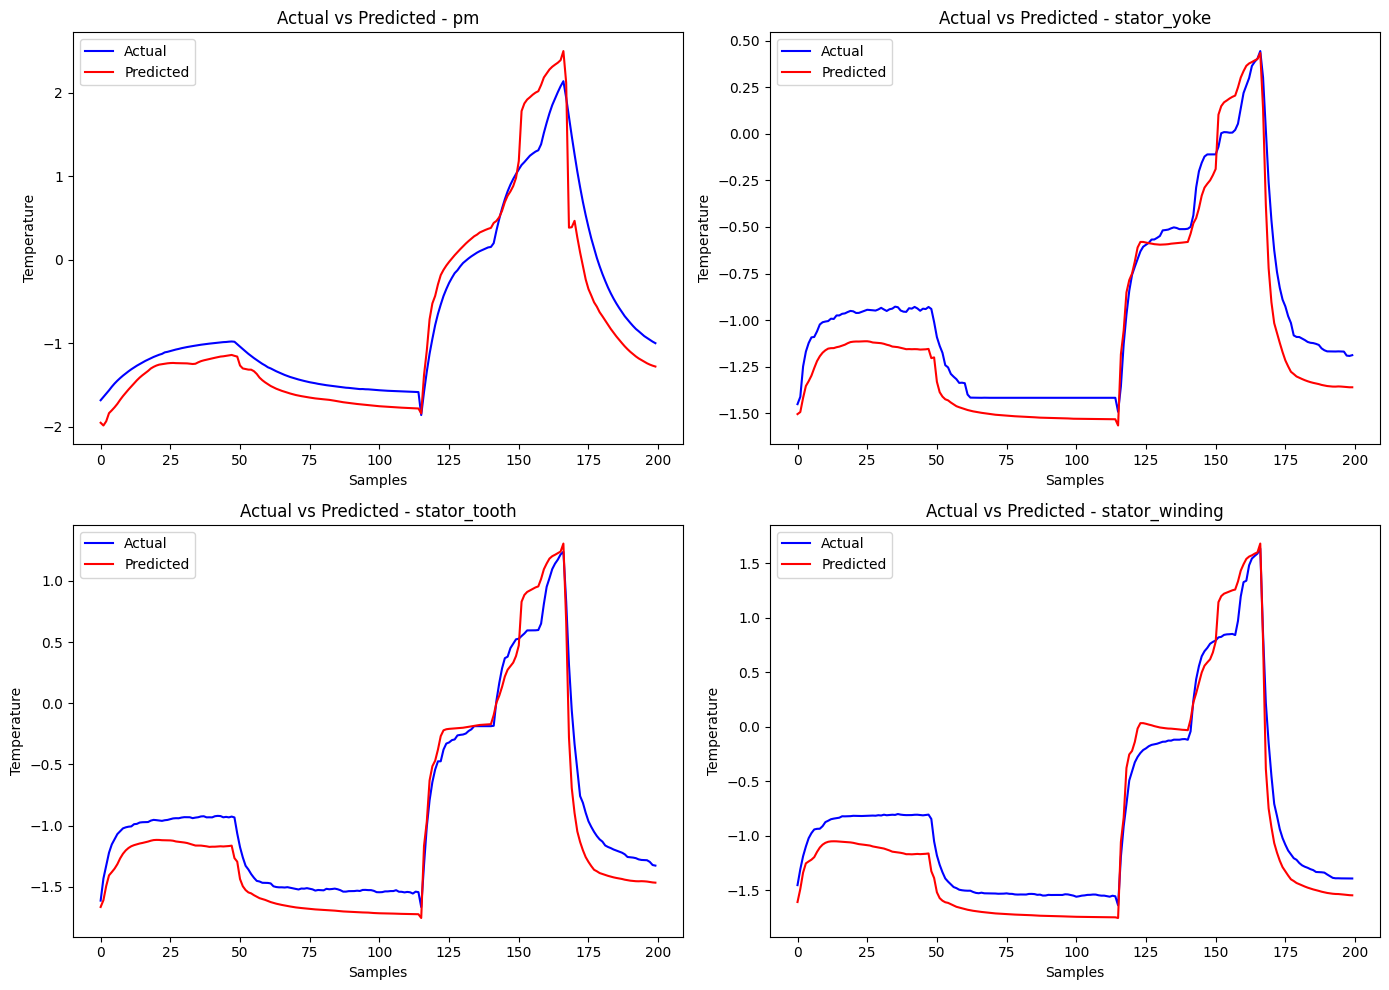

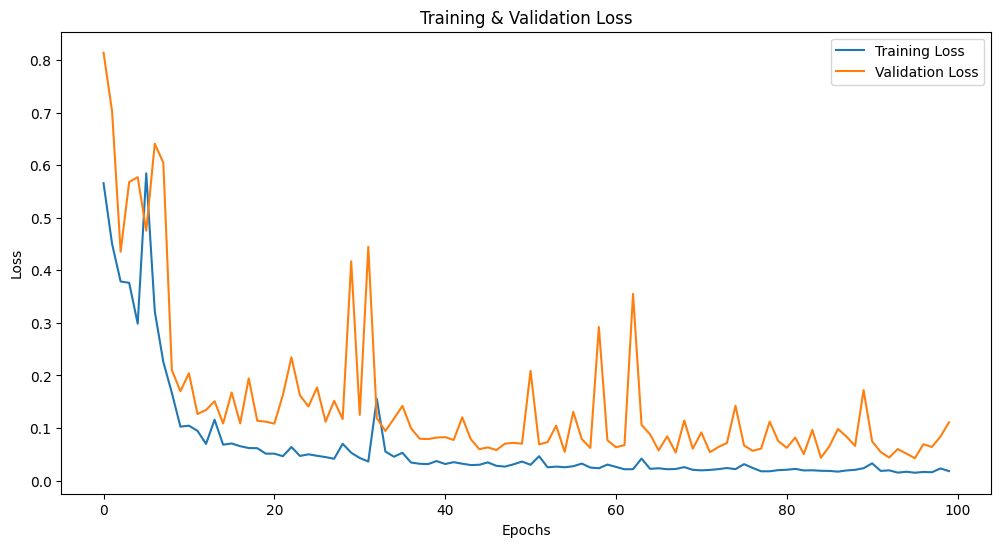

In [14]:
# Evaluate the model
test_loss, test_mae = tft_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict
y_pred = tft_model.predict(X_test)

# Optional: inverse transform (if using scalers)
# y_pred = target_scaler.inverse_transform(y_pred)
# y_test = target_scaler.inverse_transform(y_test)

import pickle

# Save training history to a file
with open('tft_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Define your target column names
target_cols = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]

# Plot predictions vs actuals for each temperature
plt.figure(figsize=(14, 10))
for i, col in enumerate(target_cols):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[:200, i], label='Actual', color='blue')
    plt.plot(y_pred[:200, i], label='Predicted', color='red')
    plt.title(f'Actual vs Predicted - {col}')
    plt.xlabel('Samples')
    plt.ylabel('Temperature')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


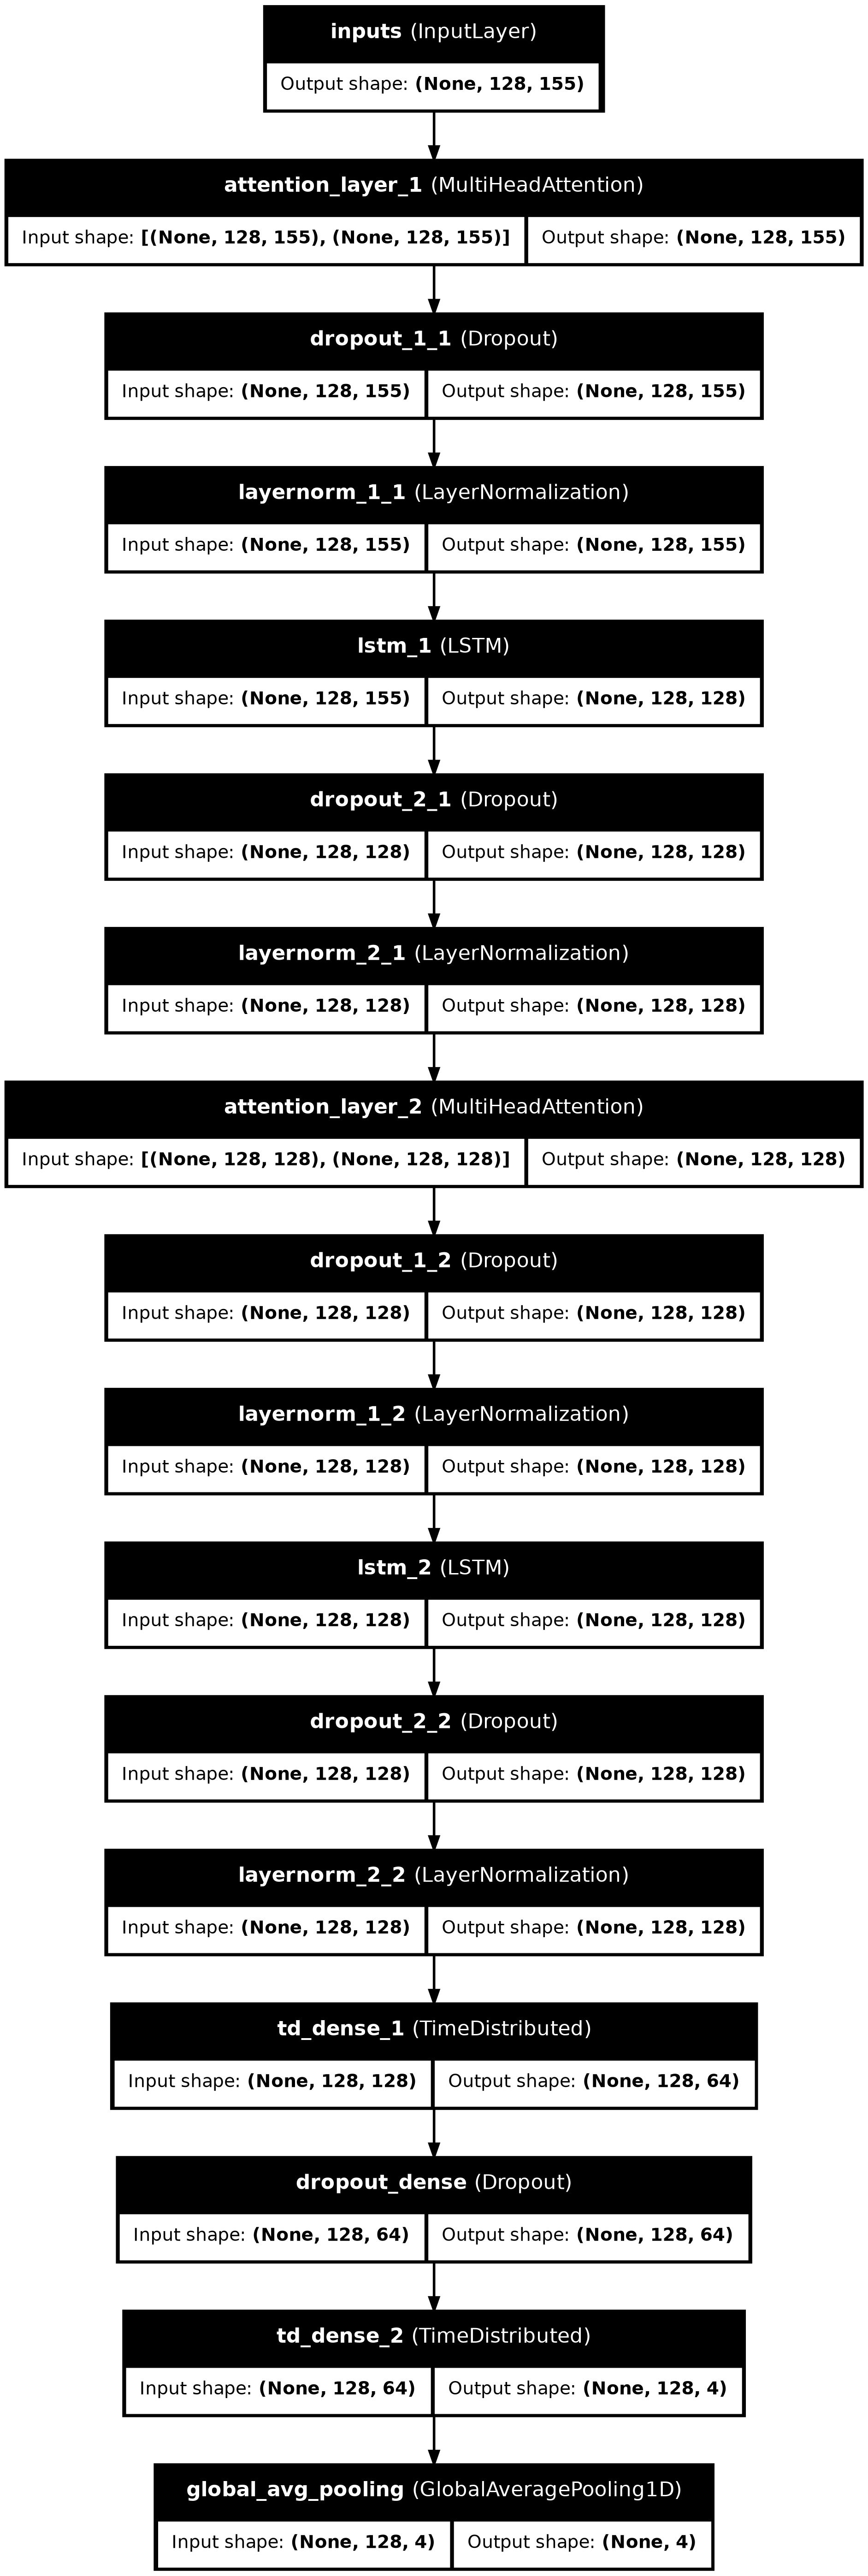

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(tft_model, show_shapes=True, show_layer_names=True, to_file='tft_model.png')


In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_feature_importance(model, X_val, y_val, metric=mean_squared_error):
    baseline_preds = model.predict(X_val)
    baseline_score = metric(y_val, baseline_preds)

    importances = []

    for i in range(X_val.shape[2]):  # Loop through each feature
        X_val_permuted = X_val.copy()
        np.random.shuffle(X_val_permuted[:, :, i])  # Shuffle feature i across all samples
        permuted_preds = model.predict(X_val_permuted)
        permuted_score = metric(y_val, permuted_preds)
        
        importance = permuted_score - baseline_score
        importances.append(importance)

    return np.array(importances)


In [18]:
importances = permutation_feature_importance(tft_model, X_val, y_val)
for i, imp in enumerate(importances):
    print(f"Feature {i}: Importance = {imp:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


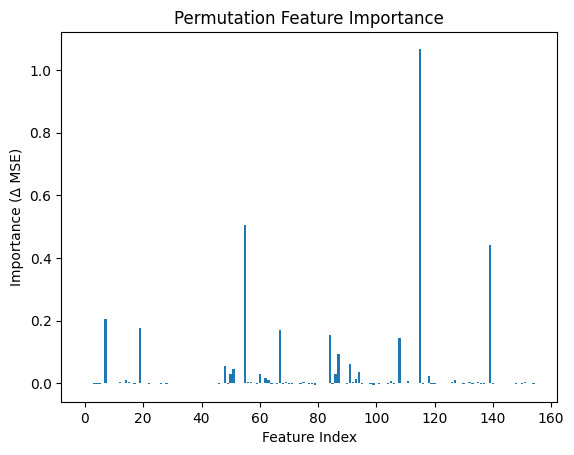

In [19]:
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance (Δ MSE)")
plt.title("Permutation Feature Importance")
plt.show()


In [21]:
import numpy as np

# Get indices of top 5 features (descending importance)
top_5_indices = np.argsort(importances)[::-1][:5]

# Print top 5
print("Top 5 important features (by index):")
for rank, idx in enumerate(top_5_indices, 1):
    print(f"{rank}. {x_cols[idx]} (index {idx}) - Importance: {importances[idx]:.4f}")


Top 5 important features (by index):
1. time_ew_rolling_mean_3600 (index 115) - Importance: 1.0671
2. time_sum (index 55) - Importance: 0.5054
3. time_ew_rolling_mean_7200 (index 139) - Importance: 0.4405
4. time (index 7) - Importance: 0.2063
5. time_lag_1 (index 19) - Importance: 0.1760
